In [ ]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

<h1> Video network basics</h1>

In [46]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
data_prefix = 'data/' # ../

from powerlaw import Fit, plot_ccdf

In [5]:
import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

In [3]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict

>>> Daily view data has been loaded!


In [48]:
### relevant network at cutoff 15
NUM_REL = 15
T = 63
edges = []
embed_indegree_dict = {embed: np.zeros((T,)) for embed in np.arange(num_videos)}  # daily indegree for each embed
embed_outdegree_dict = {embed: np.zeros((T,)) for embed in np.arange(num_videos)}  # bounded, non-Vevo removed?
daily_indegree_list = []
zero_indegree_list = []  # percentage of zero indegree for each day
num_edges_list = []  # number of total edges for each day
# num_nodes_list = []   # number of total nodes for each day -> always constant to be the 60470 XXX

for t in range(T):
    filename = 'network_{0}.p'.format((datetime(2018, 9, 1) + timedelta(days=t)).strftime('%Y-%m-%d'))
    indegree_list = []
    daily_edges = []
    with open(os.path.join(data_prefix, 'network_pickle', filename), 'rb') as fin:
        network_dict = pickle.load(fin)   # embed_tar: [(embed_src, pos_src, view_src), ...]
#         num_nodes_list.append(len(network_dict.keys()))
        
        for tar_embed in range(num_videos):
            indegree_value = 0
            for x in network_dict[tar_embed]:
                if x[1] < NUM_REL:
                    indegree_value += 1
                    daily_edges.append((x[0], tar_embed))
                    embed_outdegree_dict[x[0]][t] += 1
            embed_indegree_dict[tar_embed][t] = indegree_value
            
            indegree_list.append(indegree_value)
            
    indegree_counter = Counter(indegree_list)
    zero_indegree_list.append(indegree_counter[0] / num_videos)
    daily_indegree_list.append(indegree_list)
    num_edges_list.append(sum(indegree_list))
    edges.append(daily_edges)
#     print('>>> Finish loading day {0}...'.format(t + 1))
print('>>> Network structure has been loaded!')
# print('\n>>> Average number of edges: {0:.0f}, max: {1:.0f}, min: {2:.0f}, sum: {3:.0f}'.format(sum(num_edges_list) / len(num_edges_list), max(num_edges_list), min(num_edges_list),sum(num_edges_list)))


In [5]:
daily_outdegree_list = [[int(embed_outdegree_dict[i][t]) for i in range(num_videos)] for t in range(T)]
max_outdegree = max([max(i) for i in daily_outdegree_list])
max_indegree = max([max(i) for i in daily_indegree_list])
print("max_outdegree: ", max_outdegree)
print("max_indegree: ", max_indegree)

max_outdegree:  15
max_indegree:  1271


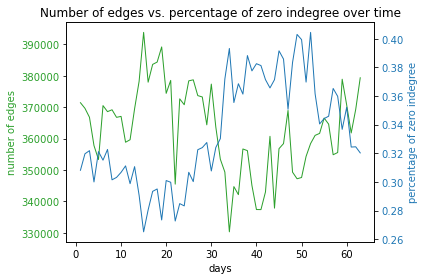

In [12]:
### Plot Number of edges vs. percentage of zero indegree over time 
fig, ax1 = plt.subplots()

ax1.set_title("Number of edges vs. percentage of zero indegree over time")

color = 'tab:green'
ax1.set_xlabel('days')
ax1.set_ylabel('number of edges', color=color)
ax1.plot([*range(1,64)], num_edges_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('percentage of zero indegree', color=color)  # we already handled the x-label with ax1
ax2.plot([*range(1,64)], zero_indegree_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# plt.plot([*range(1,64)], num_edges_list, label="Number of edges")
# plt.plot([*range(1,64)], zero_indegree_list, color="green", label="Percentage of zero indegree")
# # plt.title("Number of edges over time")
# plt.xlabel("days")
# # plt.ylabel("number of edges")
# plt.legend()
# plt.show()

It's interesting that two lines are of opposite tendency, which is opposite to artist network.

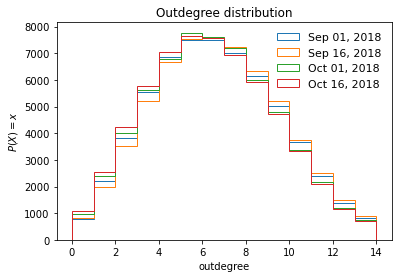

In [25]:
### Plot outdegree distribution
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(daily_outdegree_list[i], bins=[*range(0, max_outdegree, 1)], density=False, log=False, histtype="step", label=date_labels[int(i/15)])
# plt.xscale('log')
plt.title("Outdegree distribution")
plt.xlabel("outdegree")
plt.ylabel('$P(X) = x$')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

Outdegree distribution is not very interesting as it's bounded by cutoff.

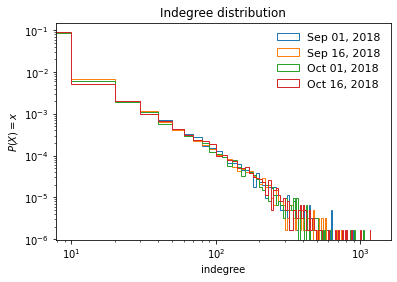

In [19]:
### Plot indegree distribution
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(daily_indegree_list[i], bins=[*range(0, math.ceil(max_indegree/10)*10, 10)], density=True, log=True, histtype="step", label=date_labels[int(i/15)])
plt.xscale('log')
plt.title("Indegree distribution")
plt.xlabel("indegree")
plt.ylabel('$P(X) = x$')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

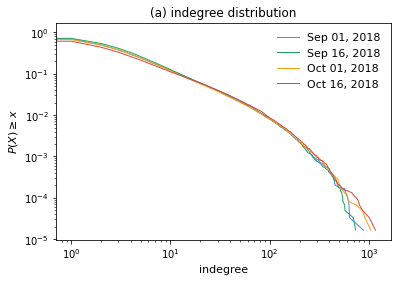

In [53]:
### powerlaw ccdf
### (pdf, 0 and fit, α = 2.02, -infer_alpha + 1)

fig, ax1 = plt.subplots()
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plot_ccdf(daily_indegree_list[i], ax=ax1, color=ColorPalette.CC4[int(i/15)], label=date_labels[int(i/15)])
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('indegree', fontsize=11)
ax1.set_ylabel('$P(X) \geq x$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Indegree distribution', fontsize=12)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

plt.show()

In [4]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [48]:
scc_list = [nx.strongly_connected_components(G) for G in graph_lst]
lscc_list = [max(scc, key=len) for scc in scc_list]

In [49]:
test = graph_lst[0].subgraph(lscc_list[0])

In [53]:
lscc_list_0 = lscc_list[0]
a = lscc_list_0.pop()
print("len: ", len(lscc_list_0), "a: ", a)
lscc_list[0].add(a)
print("len: ", len(lscc_list_0), "a: ", a)

len:  12938 a:  0
len:  12939 a:  0


In [2]:
def dfs_edges(v, graph):
    # parent = {}
    start = defaultdict(int)
#     visited = defaultdict(bool)
    end = defaultdict(int)
    # entering u
    forward_edges = defaultdict(list)
    back_edges = defaultdict(list)
    cross_edges = defaultdict(list)
    tree_edges = []
    t = 0

    def dfs(v, graph, parent=None):
        nonlocal t
        t += 1
        start[v] = t
        if parent is not None:
            tree_edges.append((parent, v))
        for n in graph.successors(v):
            if start[n] == 0:  # not visited
                dfs(n, graph, parent=v)
            elif end[n] == 0:
                back_edges[n].append(v)
            elif start[v] < start[n]:
                forward_edges[n].append(v)
            else:
                cross_edges[n].append(v)
        t += 1
        end[v] = t
    
    dfs(v, graph)
    
    return tree_edges, back_edges, forward_edges, cross_edges

def dominator_tree(v, graph):
    dt = nx.DiGraph()
    idoms = nx.immediate_dominators(graph, v)
    for k, v in idoms.items():
        if k != v:
            dt.add_edge(v, k)
    return dt

def dfs_order(v, graph, ):
    start = defaultdict(int)
    end = defaultdict(int)
    t = 0
    
    def dfs(v, graph,):
        nonlocal t
        t += 1
        start[v] = t
        for n in graph.successors(v):
            if start[n] == 0:  # not visited
                dfs(n, graph, )
        t += 1
        end[v] = t
        
    dfs(v, graph)
    
    return start, end

def edge_dominators(v, graph):    
    edge_dominator = set()
    tree_edges, back_edges, forward_edges, cross_edges = dfs_edges(v, graph)
    dt = dominator_tree(v, graph)
    start, end = dfs_order(v, dt)
    for e in tree_edges:
        if len(forward_edges[e[1]])==0 and len(cross_edges[e[1]])==0:
            flag = True
            for i in back_edges[e[1]]:  # for every back edge, e_1 dominate i
                if not ((start[e[1]] < start[i]) and (end[i] < end[e[1]])):
                    flag = False
            if flag:
                edge_dominator.add(e)
    return edge_dominator

def strong_edges(v, graph):
    de = edge_dominators(v, graph)
    for v, u in edge_dominators(v, graph.reverse()):
        de.add((u, v))
    return de

In [3]:
de = strong_edges(a, test)

NameError: name 'a' is not defined

In [63]:
counter = Counter()
for lscc in lscc_list:
    counter.update(lscc)

avg_views = []
days_in_lscc = []
ids_lscc = []
for i in counter.keys():
    ids_lscc.append(i)
    avg_views.append(embed_avg_view_dict[i])
    days_in_lscc.append(counter[i])

In [40]:
len(counter.values())/num_videos

0.5429535726045439

In [66]:
def point_filter(lv, uv, ld, ud):
    res = []
    for i in range(len(ids_lscc)):
        if lv <= avg_views[i] and avg_views[i] <= uv and ld <= days_in_lscc[i] and days_in_lscc[i] <= ud:
            res.append((ids_lscc[i], avg_views[i], days_in_lscc[i]))
    return res

In [67]:
res = point_filter(5e5, 5e6, 0, 10)
res

[(59946, 2373613.507936508, 6)]

In [72]:
embed_title_dict[59946]

'Becky G, Paulo Londra - Cuando Te Besé (Official Video)'

In [71]:
res = point_filter(3e6, 8e6, 50, 70)
res

[(36301, 7167077.079365079, 63), (60006, 3988681.698412698, 56)]

In [73]:
embed_title_dict[36301]

'Maroon 5 - Girls Like You ft. Cardi B'

In [74]:
embed_title_dict[60006]

'Becky G, Natti Natasha - Sin Pijama (Official Video)'

In [76]:
res = point_filter(1e6, 8e6, 30, 40)
res

[(1237, 1186965.1904761905, 36), (7006, 1128159.650793651, 35)]

In [77]:
embed_title_dict[1237]

'Imagine Dragons - Natural (Official Music Video)'

In [78]:
embed_title_dict[7006]

"4 Non Blondes - What's Up"

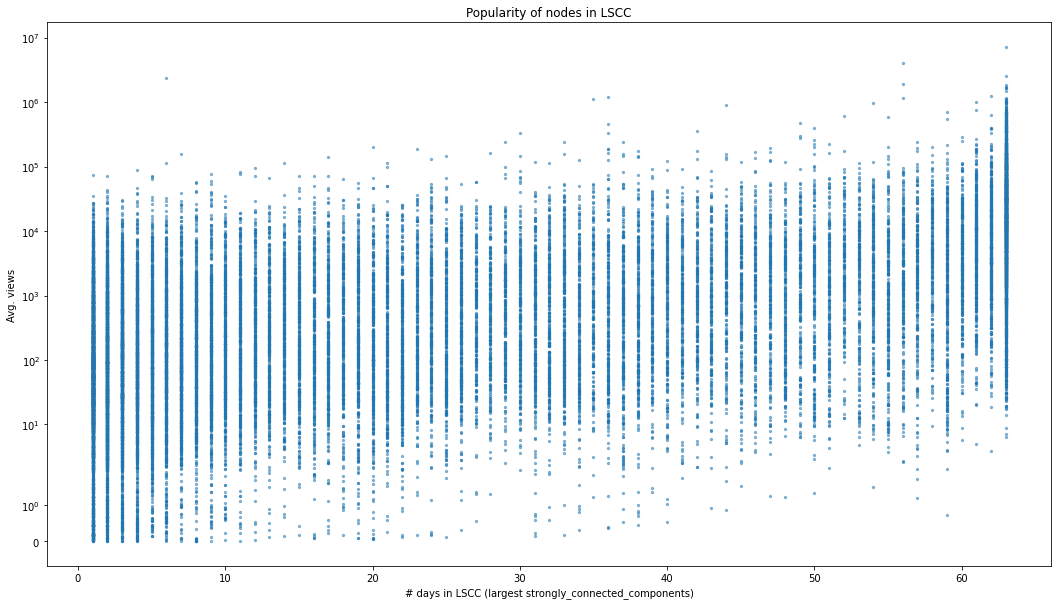

In [125]:
plt.figure(figsize=(18,10))
plt.scatter(days_in_lscc, avg_views, s=5, marker='o', alpha=0.5)
plt.title("Popularity of nodes in LSCC")
plt.xlabel("# days in LSCC (largest strongly_connected_components)")
plt.ylabel("Avg. views")
# plt.xscale('log')
plt.yscale('symlog')
plt.show();

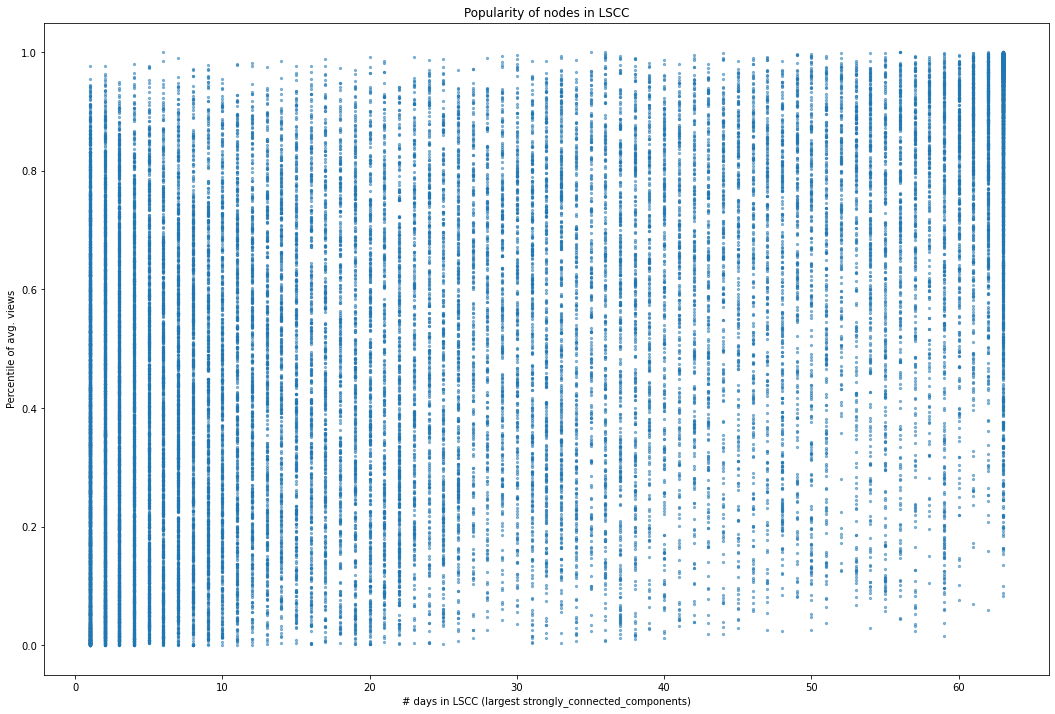

In [124]:
days_avg_views = sorted(zip(days_in_lscc, avg_views), key=lambda x: x[1])
def strict_percentile(lst):
    p_lst = []
    for i in range(len(lst)):
        j = i
        while j >= 1:
            if lst[j-1] != lst[i]:
                break
            else:
                j = j-1
        p_lst.append((j+1)/len(lst))
    return p_lst            
p_lst = strict_percentile(sorted(avg_views))
sorted_days_in_lscc =list(zip(*days_avg_views))[0]


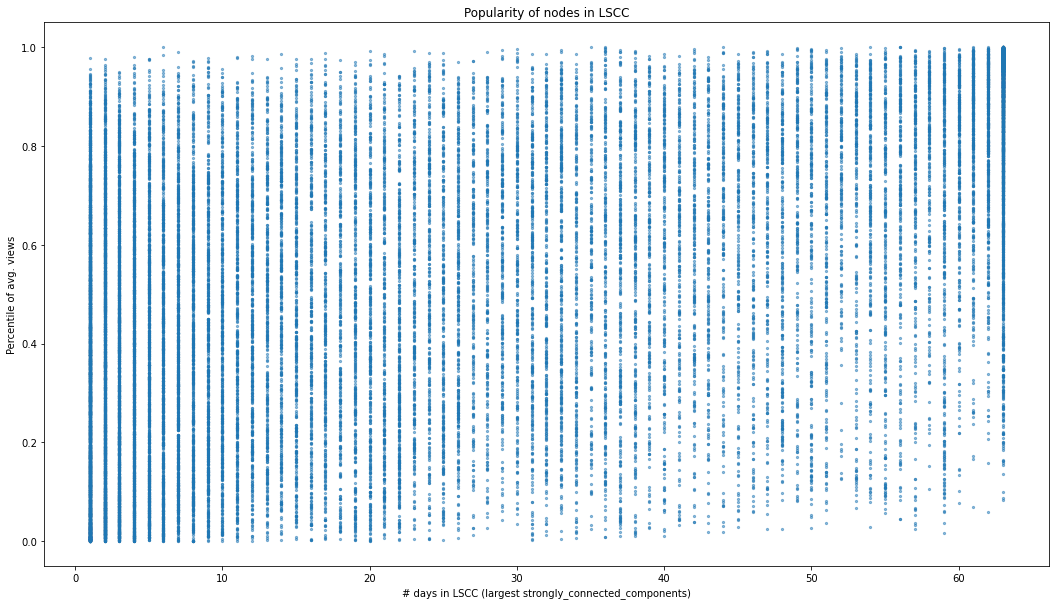

In [126]:
plt.figure(figsize=(18,10))
plt.scatter(sorted_days_in_lscc, p_lst, s=5, marker='o', alpha=0.5)
plt.title("Popularity of nodes in LSCC")
plt.xlabel("# days in LSCC (largest strongly_connected_components)")
plt.ylabel("Percentile of avg. views")
# plt.xscale('log')
# plt.yscale('symlog')
plt.show();

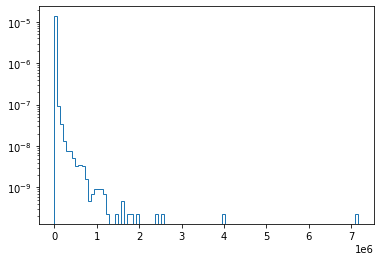

In [82]:
plt.hist(embed_avg_view_dict.values(), bins=100, density=True, log=True, histtype="step")
plt.title("avg_view distribution")
plt.show();

In [20]:
bridge_list = nx.bridges(graph_lst[0].to_undirected(), root=36301) # for G in graph_lst]
# has_bridge_list

In [21]:
c = 0
first_list = []
sec_list = [] 
for i in bridge_list:
    c += 1
    if graph_lst[0].in_degree(i[0]) >100 and graph_lst[0].in_degree(i[1]) >100:
        first_list.append(i)
    elif graph_lst[0].in_degree(i[0]) >10 and graph_lst[0].in_degree(i[1]) >10:
        sec_list.append(i)
print(c)

1768


In [24]:
embed_title_dict[37264]  # repeated, bridges across days, importance of bridge breaking factor, fraction or degree

[(57223, 22610),
 (57223, 47110),
 (57223, 2278),
 (57223, 33524),
 (2278, 22610),
 (2278, 28632),
 (2278, 47110),
 (28632, 22610),
 (28632, 33524),
 (28632, 47110),
 (47110, 33524),
 (33524, 22610)]

In [25]:
embed_title_dict[57223]  # select and visualize

'Sa-Roc - Them Vimana Jets'

In [27]:
graph_lst[0].in_degree(57223)

11

In [28]:
graph_lst[0].out_degree(57223)

9

In [87]:
# plot around
nx.has_bridges(graph_lst[1].to_undirected(), root=36301)

True

In [95]:
### creat list of length of largest strongly/weakly connected components of each day (percentage)
lscc_len_list = [len(max(nx.strongly_connected_components(G), key=len))/num_videos for G in graph_lst]
lwcc_len_list = [len(max(nx.weakly_connected_components(G), key=len))/num_videos for G in graph_lst]

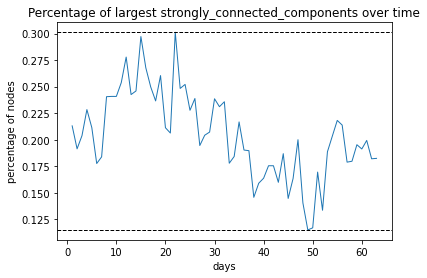

In [98]:
### Plot percentage of largest strongly_connected_components over time
plt.plot([*range(1,64)], lscc_len_list)
plt.axhline(y=max(lscc_len_list), color='k', linestyle='--', zorder=30)
plt.axhline(y=min(lscc_len_list), color='k', linestyle='--', zorder=30)
plt.title("Percentage of largest strongly_connected_components over time")
plt.xlabel("days")
plt.ylabel("percentage of nodes")
plt.show();

Surprising. The percentage of LSCC changes in a relatively large range.

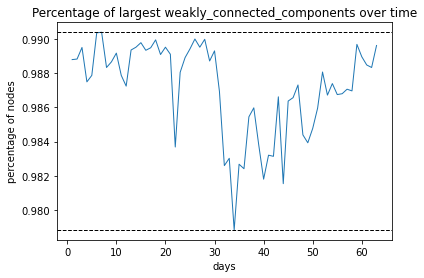

In [97]:
### Plot percentage of largest weakly_connected_components over time
plt.plot([*range(1,64)], lwcc_len_list)
plt.axhline(y=max(lwcc_len_list), color='k', linestyle='--', zorder=30)
plt.axhline(y=min(lwcc_len_list), color='k', linestyle='--', zorder=30)
plt.title("Percentage of largest weakly_connected_components over time")
plt.xlabel("days")
plt.ylabel("percentage of nodes")
plt.show();

No supurising, since nearly all videos are weakly connected.

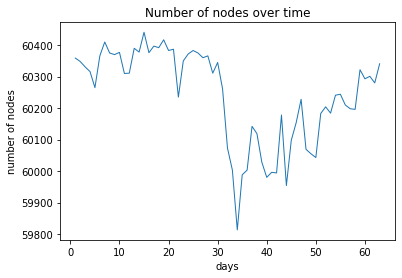

In [40]:
### Plot number of nodes actually in the network graph over time
num_nodes_list = [nx.number_of_nodes(G) for G in graph_lst]
plt.plot([*range(1,64)], num_nodes_list)
plt.title("Number of nodes over time")
plt.xlabel("days")
plt.ylabel("number of nodes")
plt.show();

Missing videos are due to they are pointing to and pointed from only non-Vevo videos?

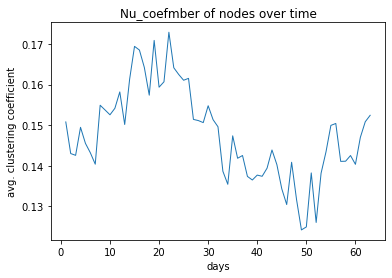

In [39]:
### Plot Avg. clustering coefficient over tim ~ 5 MIN
def avg_over_iterator(iterator):
    s = 0
    c = 0
    for j in iterator.values():
        s += j
        c += 1
    return s/c

cluster_list = [nx.clustering(G) for G in graph_lst]
avg_cluster_coef_list = [avg_over_iterator(i) for i in cluster_list]
plt.plot([*range(1,64)], avg_cluster_coef_list)
plt.title("Avg. clustering coefficient over time")
plt.xlabel("days")
plt.ylabel("avg. clustering coefficient")
plt.show();

Clustering coefficient. First 30 days differ from last 30 days.

In [29]:
### Caculate pagerank and eigenvector centrality 15-20 Min
if not os.path.exists(os.path.join(data_prefix, "video_env_list_15.pkl")):
    env_list = [nx.eigenvector_centrality(G, max_iter=500) for G in graph_lst]
    with open(os.path.join(data_prefix, "video_env_list_15.pkl"), 'wb') as fout:
            pickle.dump(env_list, fout)
else:
    with open(os.path.join(data_prefix, "video_env_list_15.pkl"), 'rb') as fin:
        env_list = pickle.load(fin)

if not os.path.exists(os.path.join(data_prefix, "video_pr_list_15.pkl")):
    pr_list = [nx.pagerank_scipy(G) for G in graph_lst]
    with open(os.path.join(data_prefix, "video_pr_list_15.pkl"), 'wb') as fout:
            pickle.dump(pr_list, fout)
else:
    with open(os.path.join(data_prefix, "video_pr_list_15.pkl"), 'rb') as fin:
        pr_list = pickle.load(fin)

In [ ]:
### If the graph is not completely connected, the closeness centrality is coumputed for each connected part separately.

In [43]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

def get_hi_kl_list(lst):
    maximum = max([max(i.values()) for i in lst])
    minimum = min([min(i.values()) for i in lst])
    bins = np.linspace(minimum, maximum, 1000)  ## use the same set of bins
    pre, _, _ = plt.hist(list(lst[0].values()),bins=bins, log=True, density=True);
    hi_list = []
    kl_list = []
    for i in range(1, len(lst)):
        h2, _, _ = plt.hist(list(lst[i].values()),bins=bins, log=True, density=True);
        hi_list.append(histogram_intersection(pre, h2, bins))

        pre_np = np.array(pre)+1
        h2_np = np.array(h2)+1
        kl_list.append(sp.stats.entropy(h2_np, pre_np))
        
        pre = h2
        
    return hi_list, kl_list

pr_hi_list, pr_kl_list= get_hi_kl_list(pr_list);
env_hi_list, env_kl_list= get_hi_kl_list(env_list);

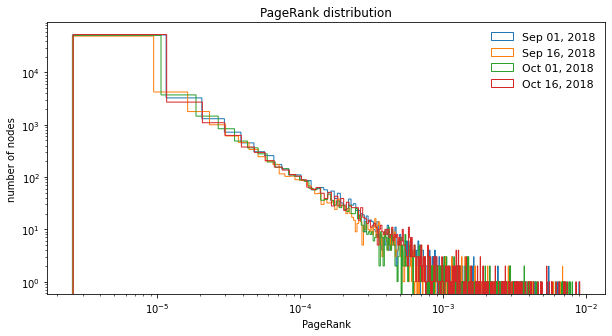

In [33]:
### take 4 days as an example
plt.figure(figsize=(10,5))
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(list(pr_list[i].values()),bins=1000, log=True, histtype="step", label=date_labels[int(i/15)]) # density=True,  
plt.title("PageRank distribution")
plt.xlabel("PageRank")
plt.ylabel("number of nodes")
plt.xscale('log')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

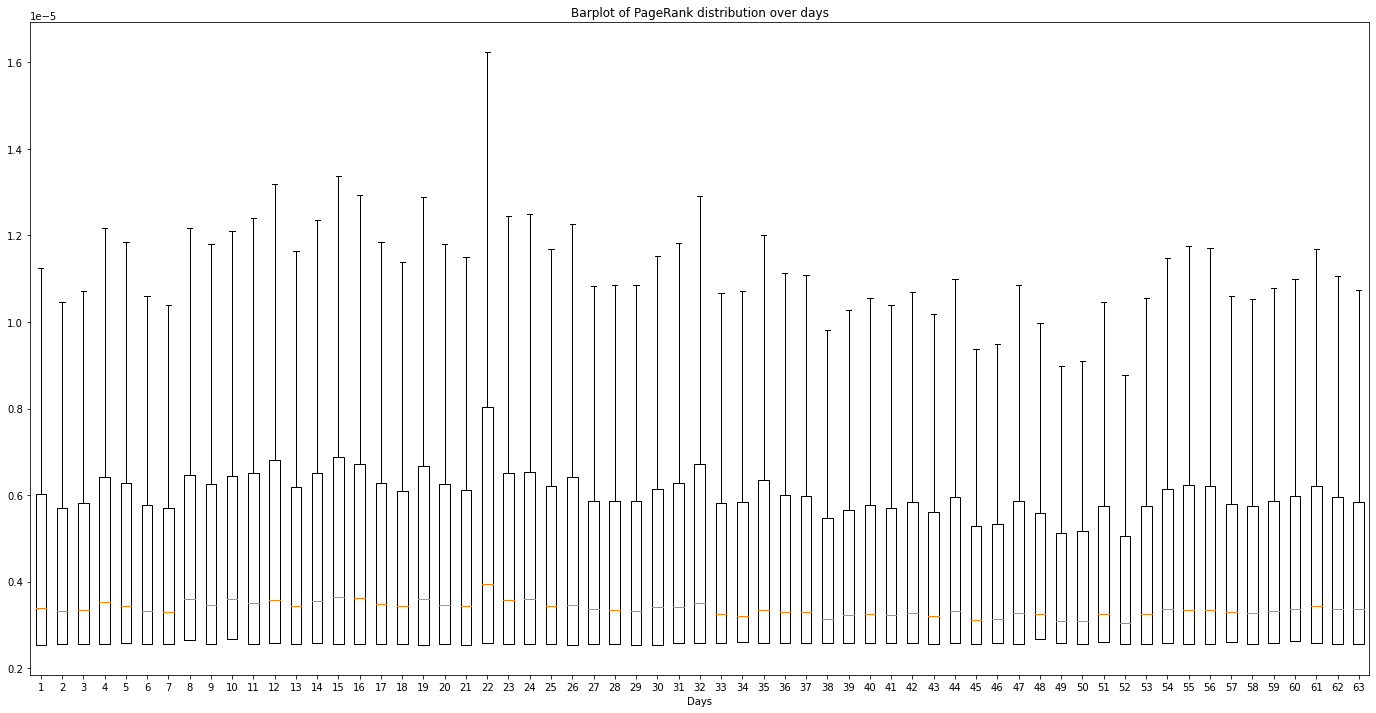

In [34]:
### pagerank analysis
### Plot boxplot
plt.figure(figsize=(24,12))
plt.boxplot([list(i.values()) for i in pr_list], labels=[*range(1,64)], showfliers=False)
## there exists many large outliers being hidden, which may actually be the hot spots we interested in
plt.title("Barplot of PageRank distribution over days")
plt.xlabel("Days")
plt.show();

There exists many large outliers being hidden. Outliers are videos of high pagerank.

KL-Divergence and histigram intersection both need the same set of bins. 
I use the maximum and minimum value over 63 days as the boundary.

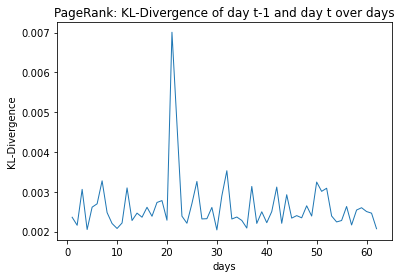

In [35]:
### PageRank: KL-Divergence
plt.plot([*range(1, 63)], pr_kl_list)
plt.title("PageRank: KL-Divergence of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("KL-Divergence")
plt.show()

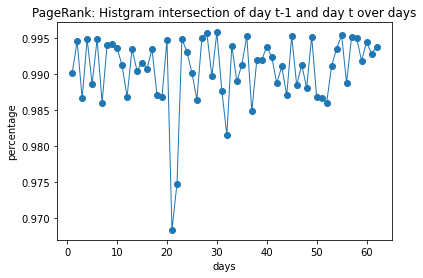

In [36]:
### PageRank: Histgram intersection
plt.plot([*range(1, 63)], pr_hi_list, "o-")
plt.title("PageRank: Histgram intersection of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("percentage")
plt.show()

From above 2 figures, day 21 is interesting.

There is somthing wrong with engenvector centrality. 
I don't know why nx.eigenvector_centrality_numpy return eigenvectors containg negative values. And nx.eigenvector_centrality gives extremely small values.
I don't think the figures below are useful.

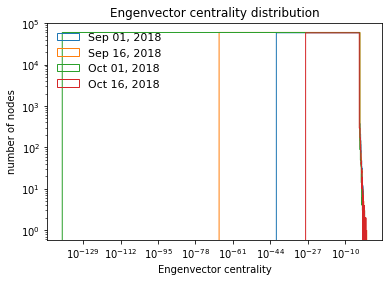

In [37]:
### Engenvector centrality distibution: take 4 days as an example
# plt.figure(figsize=(10,5))
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(list(env_list[i].values()),bins=1000, log=True, histtype="step", label=date_labels[int(i/15)]) # density=True,  
plt.title("Engenvector centrality distribution")
plt.xlabel("Engenvector centrality")
plt.ylabel("number of nodes")
plt.xscale('log')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();
## Extremely distributed if not logarized

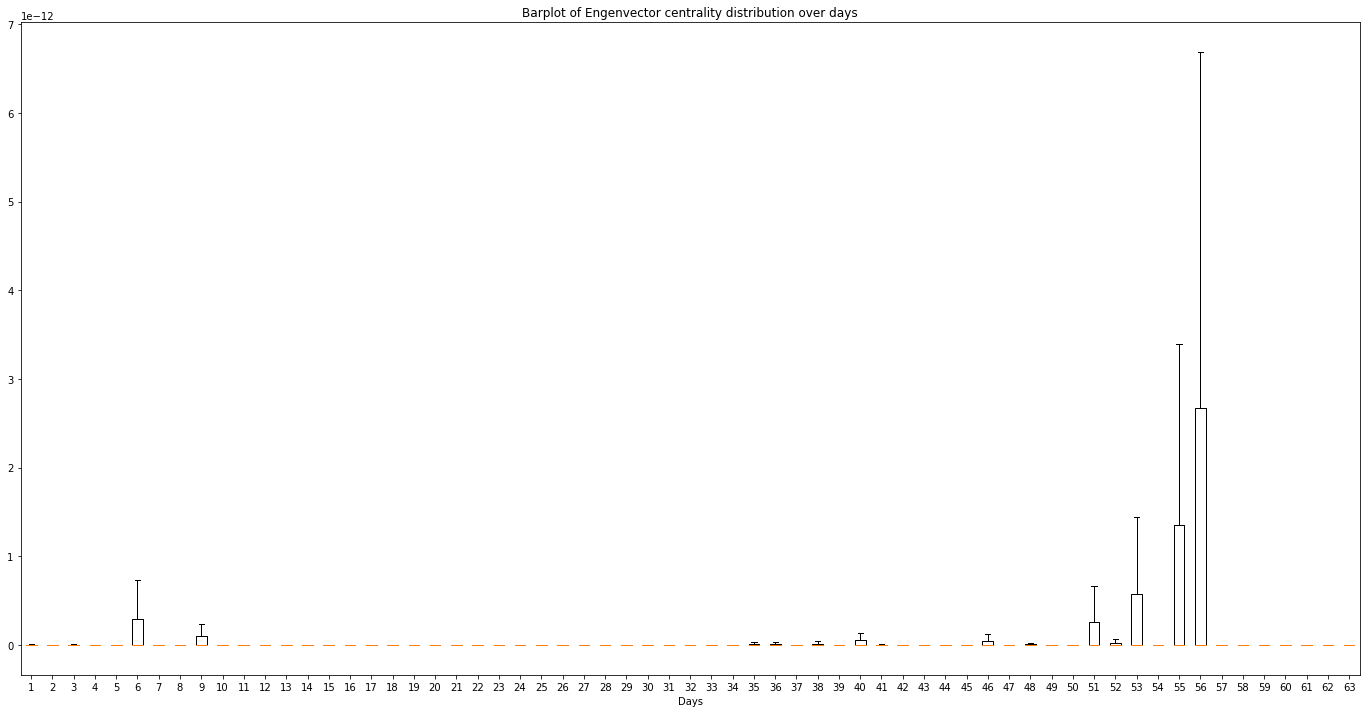

In [38]:
### Engenvector centrality boxplot
plt.figure(figsize=(24,12))
plt.boxplot([list(i.values()) for i in env_list], labels=[*range(1,64)], showfliers=False)
## there exists many large outliers being hidden, which may actually be the hot spots we interested in
plt.title("Barplot of Engenvector centrality distribution over days")
plt.xlabel("Days")
plt.show();

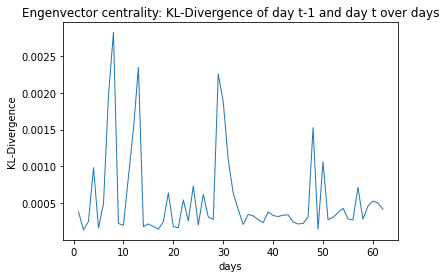

In [39]:
### Engenvector centrality KL-Divergence
plt.plot([*range(1, 63)], env_kl_list)
plt.title("Engenvector centrality: KL-Divergence of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("KL-Divergence")
plt.show()

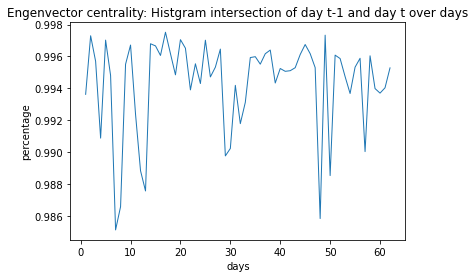

In [40]:
### Engenvector centrality Histgram intersection
plt.plot([*range(1, 63)], env_hi_list)
plt.title("Engenvector centrality: Histgram intersection of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("percentage")
plt.show()